# News classification with pre-trained transformers based on BERT


In [3]:
import tensorflow as tf
import transformers
from transformers import AutoTokenizer, TFAutoModel

#import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras import losses

import pandas as pd
pd.set_option('display.max_colwidth', 150)
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm, CenteredNorm

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import json
import shutil
import os
import zipfile

# For nicer prints
from IPython.display import display

tf_version = tf.__version__
print(tf_version)

2.14.0


## Load the data into a pandas dataframe
We next load the data from the provided JSON into a pandas dataframe. Note, that loading the file with the module `json` raises an error (see the [discussion](https://www.kaggle.com/rmisra/news-category-dataset/discussion/191283)).

In [7]:
def load_data(file_path):
    df = pd.read_json(file_path, lines = True)
    df['category'] = pd.Categorical(df['category'])
    return df[["headline", "category"]]

dataframe = load_data('News_Category_Dataset_v3.json')
dataframe.head()

,headline,category
0,Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters,U.S. NEWS
1,"American Airlines Flyer Charged, Banned For Life After Punching Flight Attendant On Video",U.S. NEWS
2,23 Of The Funniest Tweets About Cats And Dogs This Week (Sept. 17-23),COMEDY
3,The Funniest Tweets From Parents This Week (Sept. 17-23),PARENTING
4,Woman Who Called Cops On Black Bird-Watcher Loses Lawsuit Against Ex-Employer,U.S. NEWS


# Data pre-processing
## Exploring the data
Inspecting and exploring our data is majorly important. We have to look out for the following issues:
- Missing data
- Synonymous categories, e.g., `ARTS & CULTURE` and `CULTURE & ARTS`
- Imbalanced distribution of categories

[Google](https://developers.google.com/machine-learning/guides/text-classification/step-2) provides a helpful guide for exploring text data.

In [11]:
def explore_data(df, number_of_bins=30, text_only=False):
    stats = get_key_statistics_about_data(df)
    print("Number of samples:", stats["n_samples"])
    print("Number of classes:", stats["n_classes"])
    print("Number of empty headlines:", stats["n_empty_headlines"])
    print("Number of missing headlines:", stats["n_missing_headlines"])
    print("Number of missing classes:", stats["n_missing_classes"])
    print("Samples per class: Min:", stats["min_n_samples_per_class"], "Median:", stats["median_n_samples_per_class"],
         "Max:", stats["max_n_samples_per_class"])
    print("Words per sample: Min:", stats["min_n_words_per_sample"], "Median:", stats["median_n_words_per_sample"],
         "Max:", stats["max_n_words_per_sample"])
    print("Samples / Median number of words per sample:", stats["n_samples"] / stats["median_n_words_per_sample"])
    print()
    display(df["category"].value_counts().to_frame())
    
    if not text_only:
        plot_class_distribution(df["category"])

        plot_word_count_distribution(df["headline"], bins=number_of_bins)
        plot_frequency_distribution_of_ngrams(df["headline"])
    
    
def get_key_statistics_about_data(df):
    ret = dict()
    ret["n_samples"] = len(df)
    ret["n_classes"] = len(df["category"].unique())
    ret["n_missing_headlines"] = df["headline"].isnull().sum()
    ret["n_empty_headlines"] = len(df[df["headline"] == ""])
    ret["n_missing_classes"] = df["category"].isnull().sum()
    number_of_words_per_sample = df["headline"].apply(lambda x: len(x.split()))
    ret["n_words_per_sample"] = number_of_words_per_sample
    ret["min_n_words_per_sample"] = number_of_words_per_sample.min()
    ret["median_n_words_per_sample"] = number_of_words_per_sample.median()
    ret["max_n_words_per_sample"] = number_of_words_per_sample.max()
    number_of_samples_per_class = df["category"].value_counts()
    ret["min_n_samples_per_class"] = number_of_samples_per_class.min()
    ret["median_n_samples_per_class"] = number_of_samples_per_class.median()
    ret["max_n_samples_per_class"] = number_of_samples_per_class.max()
    
    return ret


# inspired by https://github.com/google/eng-edu/blob/main/ml/guides/text_classification/explore_data.py
def plot_class_distribution(labels):
    counts = labels.value_counts()
    plt.figure(figsize=(16, 8))
    plt.bar(counts.index, counts, width=0.8, color='b')
    plt.xlabel('Class')
    plt.ylabel('Number of samples')
    plt.title('Class distribution')
    plt.xticks(counts.index, counts.index, rotation=90)
    plt.show()
    

def plot_word_count_distribution(sample_texts, bins=30):
    plt.figure(figsize=(16, 8))
    plt.hist([len(s.split()) for s in sample_texts], bins)
    plt.xlabel('Word count')
    plt.ylabel('Number of samples')
    plt.title('Word count distribution')
    plt.show()


def plot_frequency_distribution_of_ngrams(sample_texts,
                                          ngram_range=(1, 2),
                                          num_ngrams=50):
    # Create args required for vectorizing.
    kwargs = {
            'ngram_range': (1, 1),
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word',  # Split text into word tokens.
    }
    vectorizer = CountVectorizer(**kwargs)

    # This creates a vocabulary (dict, where keys are n-grams and values are
    # idxices). This also converts every text to an array the length of
    # vocabulary, where every element idxicates the count of the n-gram
    # corresponding at that idxex in vocabulary.
    vectorized_texts = vectorizer.fit_transform(sample_texts)

    # This is the list of all n-grams in the index order from the vocabulary.
    all_ngrams = list(vectorizer.get_feature_names())
    num_ngrams = min(num_ngrams, len(all_ngrams))
    # ngrams = all_ngrams[:num_ngrams]

    # Add up the counts per n-gram ie. column-wise
    all_counts = vectorized_texts.sum(axis=0).tolist()[0]

    # Sort n-grams and counts by frequency and get top `num_ngrams` ngrams.
    all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
        zip(all_counts, all_ngrams), reverse=True)])
    ngrams = list(all_ngrams)[:num_ngrams]
    counts = list(all_counts)[:num_ngrams]

    idx = np.arange(num_ngrams)
    plt.figure(figsize=(16, 8))
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('N-grams')
    plt.ylabel('Frequencies')
    plt.title('Frequency distribution of n-grams')
    plt.xticks(idx, ngrams, rotation=45)
    plt.show()

Number of samples: 209527
Number of classes: 42
Number of empty headlines: 6
Number of missing headlines: 0
Number of missing classes: 0
Samples per class: Min: 1014 Median: 3362.5 Max: 35602
Words per sample: Min: 0 Median: 10.0 Max: 44
Samples / Median number of words per sample: 20952.7



,count
category,
POLITICS,35602
WELLNESS,17945
ENTERTAINMENT,17362
TRAVEL,9900
STYLE & BEAUTY,9814
PARENTING,8791
HEALTHY LIVING,6694
QUEER VOICES,6347
FOOD & DRINK,6340


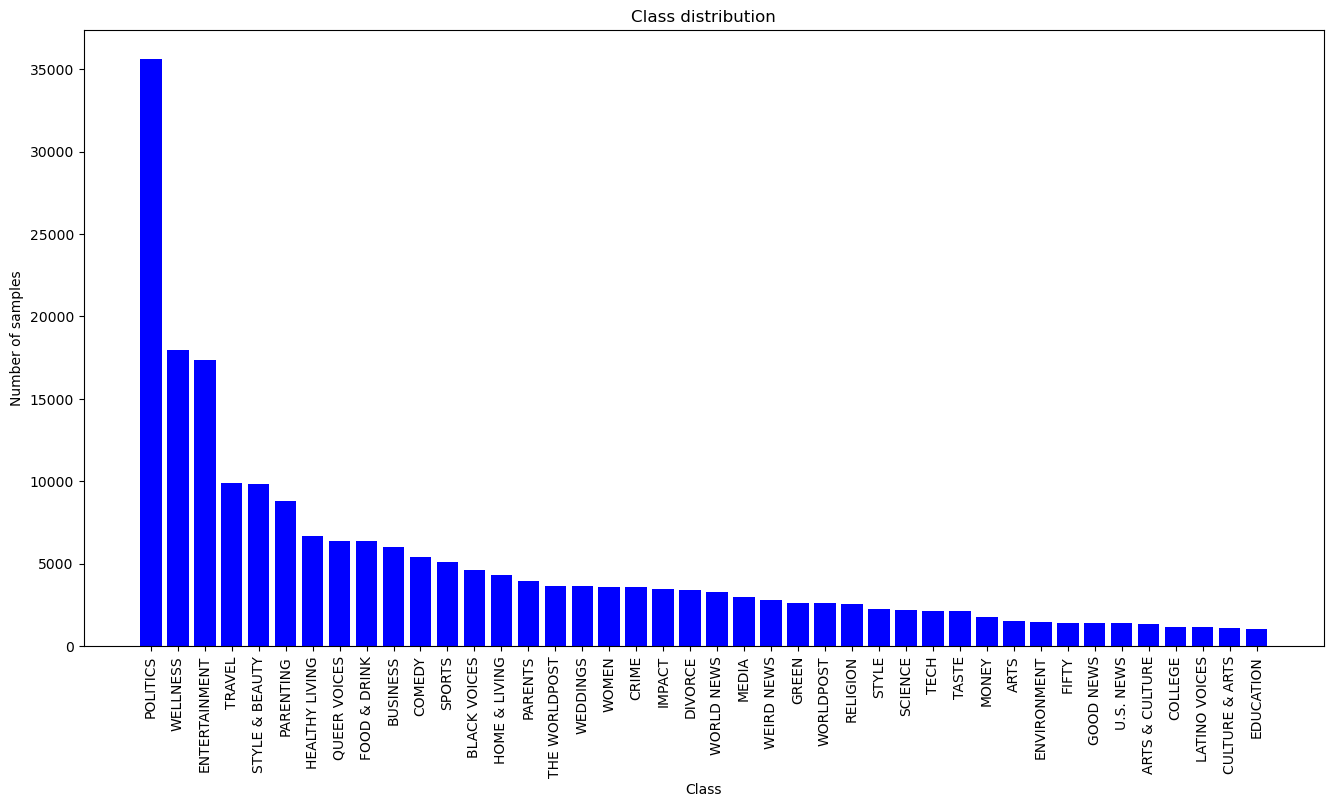

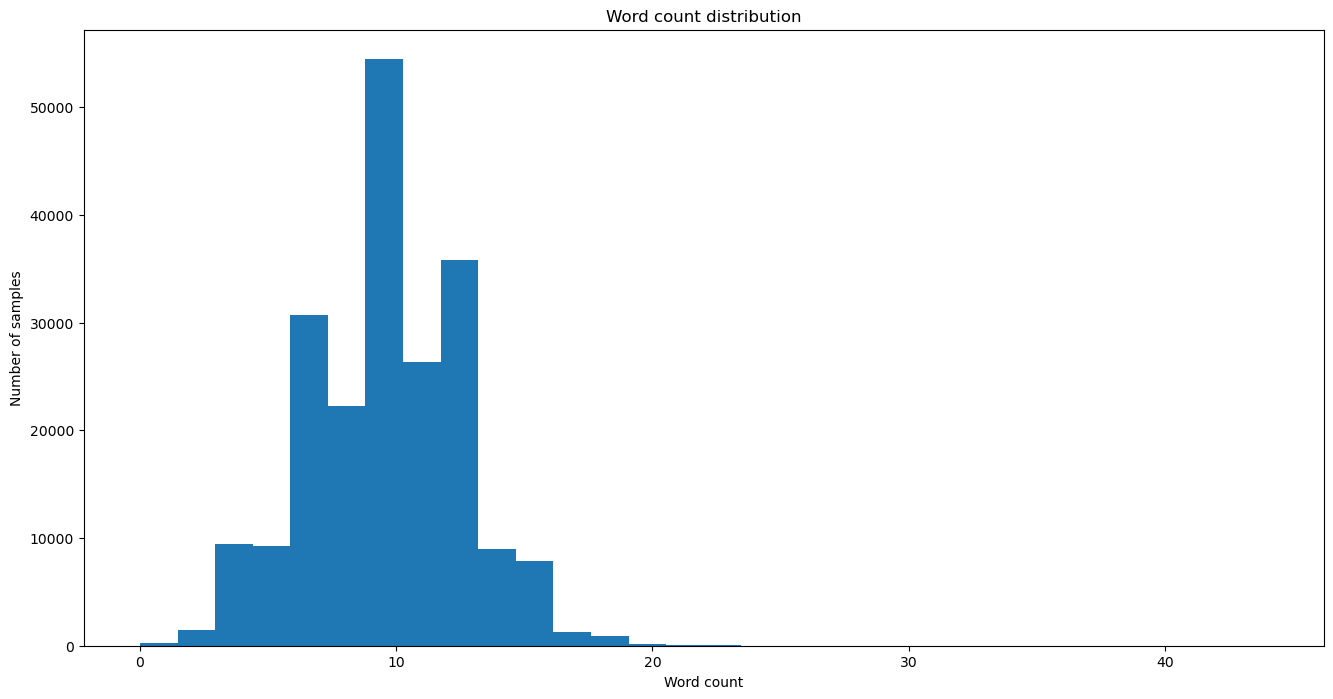

AttributeError: 'CountVectorizer' object has no attribute 'get_feature_names'

In [12]:
explore_data(dataframe)

### Conclusion of our data inspection
The take aways are:
- We have empty headlines. There are two ways of dealing with missing data.

    1. We could impute missing data
    2. We could delete missing data

  Imputation can be a difficult problem in itself and usually we would choose imputation if we had to deal with a lot of missing data. Since we only have 6 missing headlines we can simply delete the 6 units.
- Many categories are synonymous or at least equivalent. We do the following mapping

| From | To |
| --- | --- |
| THE WORLDPOST | WORLD NEWS |
| WORLDPOST | WORLD NEWS |
| ARTS | ARTS & CULTURE |
| CULTURE & ARTS | ARTS & CULTURE |
| HEALTHY LIVING | WELLNESS |
| PARENTING | PARENTS |
| STYLE | STYLE & BEATUY |
| GREEN | ENVIRONMENT |
| TASTE | FOOD & DRINK |
| MONEY | BUSINESS |
    
- We have imbalanced data. I approached this issue by computing class weights, i.e., penalizing miss-classifications for small categories more severely than large categories. The problem with that was that we do not have disjunct categories. In fact, many categories like `WOMEN`, `BLACK VOICES`, `QUEER VOICES`, etc. can be considered sub-categories of`POLITICS`. Furthermore, many headlines, which I would categorize as one of the sub-categories, are classified as `POLITICS`. From a human point-of-view both classifications would be correct. However, for the standard accuracy measurement it is considered an error. Now imagine there are a lot of such cases and we would nudge our classifier to prefer the sub-category if in doubt. Then we would get a worse accuracy as the `POLITICS` category is more prevelant and more often the correct class. 

In [13]:
dataframe = dataframe[dataframe["headline"] != ""]

def combine_categories(category):
    # THE WORLDPOST becomes WORLD NEWS
    if category == "THE WORLDPOST":
        return "WORLD NEWS"
    # WORLDPOST becomes WORLD NEWS
    if category == "WORLDPOST":
        return "WORLD NEWS"
    # ARTS becomes ARTS & CULTURE
    if category == "ARTS":
        return "ARTS & CULTURE"
    # CULTURE & ARTS becomes ARTS & CULTURE
    if category == "CULTURE & ARTS":
        return "ARTS & CULTURE"
    # HEALTHY LIVING becomes WELLNESS
    if category == "HEALTHY LIVING":
        return "WELLNESS"
    # PARENTING becomes PARENTS
    if category == "PARENTING":
        return "PARENTS"
    # STYLE becomes STYLE & BEAUTY
    if category == "STYLE":
        return "STYLE & BEAUTY"
    # GREEN becomes ENVIRONMENT
    if category == "GREEN":
        return "ENVIRONMENT"
    # TASTE becomes FOOD & DRINK
    if category == "TASTE":
        return "FOOD & DRINK"
    # MONEY becomes BUSINESS
    if category == "MONEY":
        return "BUSINESS"
    return category

dataframe["category"] = dataframe["category"].map(combine_categories)
dataframe['category'] = pd.Categorical(dataframe['category'])

C:\Users\saika\AppData\Local\Temp\ipykernel_34672\379998513.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["category"] = dataframe["category"].map(combine_categories)
C:\Users\saika\AppData\Local\Temp\ipykernel_34672\379998513.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['category'] = pd.Categorical(dataframe['category'])


Again we inspect the data.

Number of samples: 209521
Number of classes: 32
Number of empty headlines: 0
Number of missing headlines: 0
Number of missing classes: 0
Samples per class: Min: 1014 Median: 3787.5 Max: 35601
Words per sample: Min: 1 Median: 10.0 Max: 44
Samples / Median number of words per sample: 20952.1



,count
category,
POLITICS,35601
WELLNESS,24639
ENTERTAINMENT,17362
PARENTS,12746
STYLE & BEAUTY,12068
TRAVEL,9900
WORLD NEWS,9541
FOOD & DRINK,8436
BUSINESS,7747


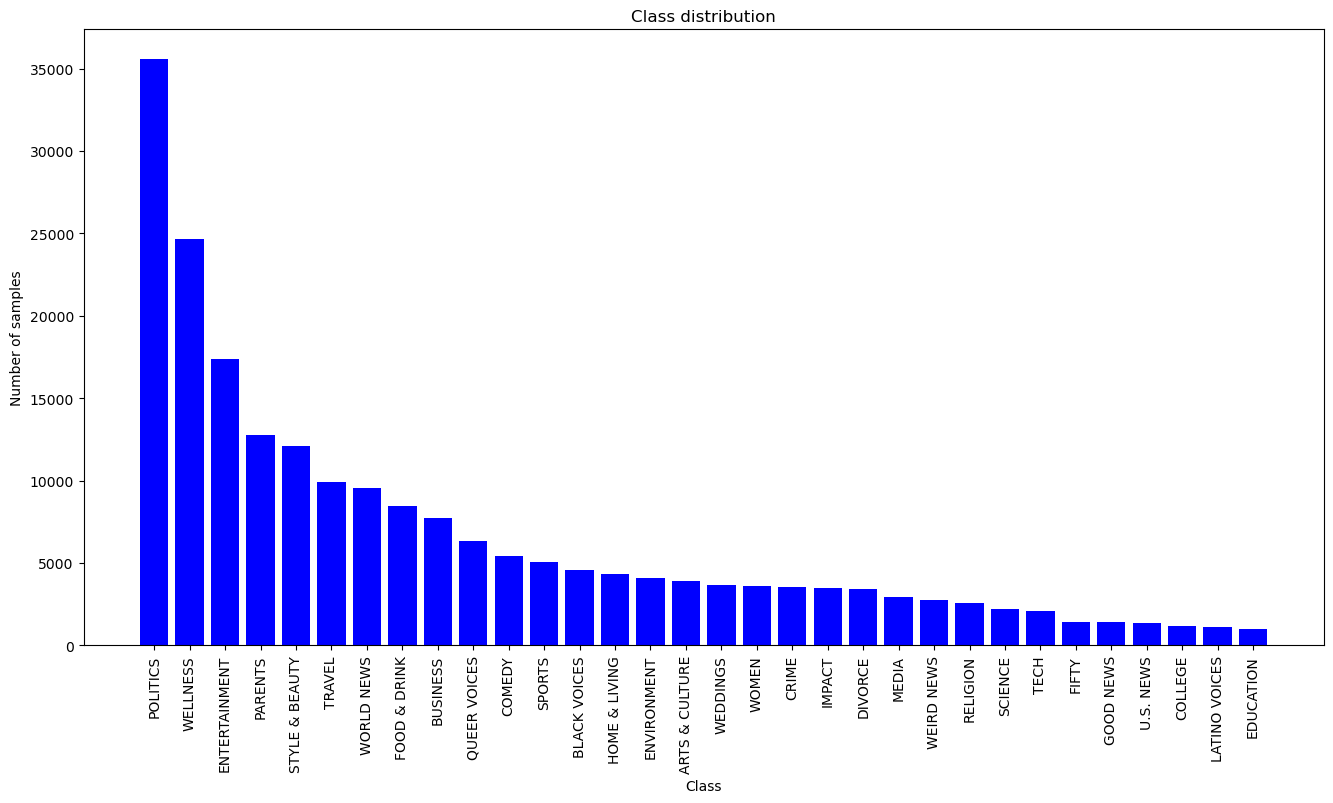

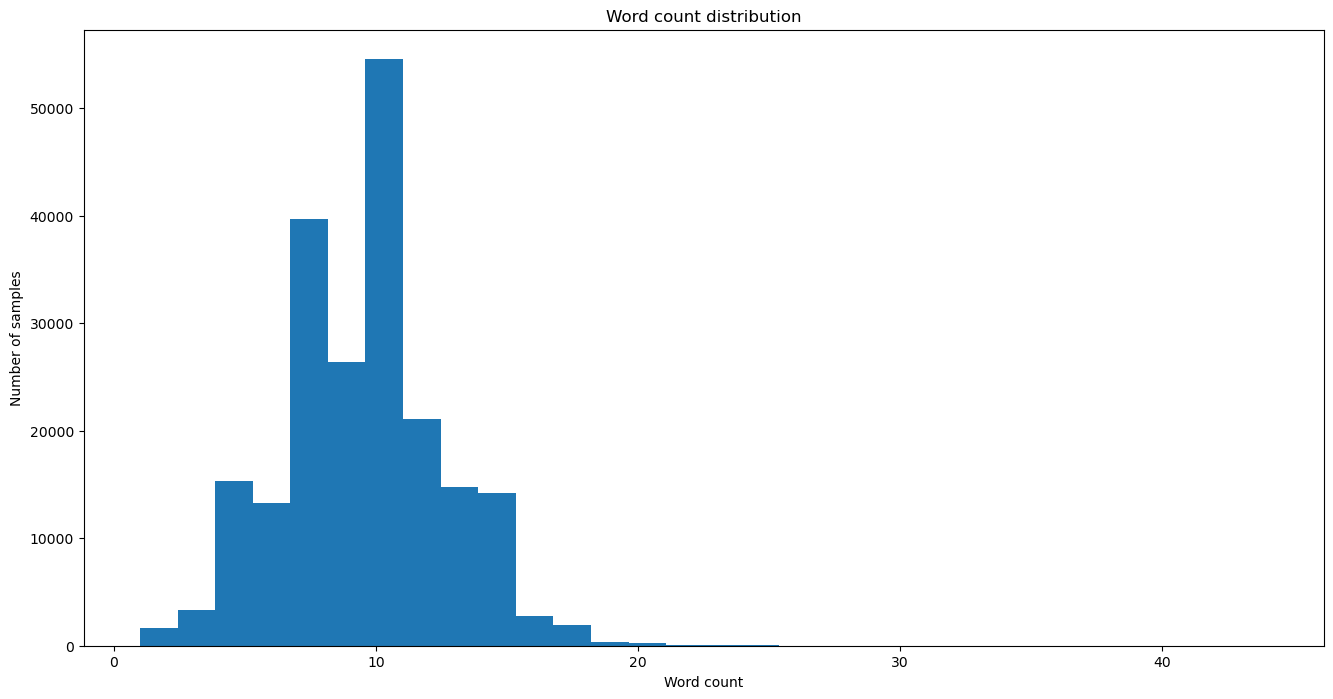

AttributeError: 'CountVectorizer' object has no attribute 'get_feature_names'

In [14]:
explore_data(dataframe, text_only=False)

Let's read some headline of certain categories to better understand what kind of articles the categories comprise.

### FIFTY category

In [15]:
display(dataframe[dataframe["category"] == "FIFTY"])

,headline,category
43952,"Love, Facebook and Infidelity",FIFTY
47074,"Boomers Were Time's ""Man of the Year"" Fifty Years Ago",FIFTY
47660,Be Grateful At The Holidays For Sprinkles Of Happiness,FIFTY
47711,A No Bullsh-t Holiday Letter,FIFTY
48303,How Our Vocabulary Gives Away Our Age,FIFTY
...,...,...
133470,Middle-aged and Invisible at Coachella,FIFTY
133509,How A Dinner Party Changed My Outlook On Aging,FIFTY
133510,What Kind Of Inheritance Do You Really Owe Your Kids?,FIFTY
133522,Eight Factors To Consider When Choosing Your Overseas Retirement Destination,FIFTY


The category `FIFTY` mostly includes headlines aiming for people of age 50.

### IMPACT category

In [16]:
display(dataframe[dataframe["category"] == "IMPACT"])

,headline,category
3834,Why You Shouldn't Recycle Receipts,IMPACT
3931,How One Of The World's Rarest Hummingbirds Is Helping Save The Cloud Forests Of Peru,IMPACT
3964,Companies Are Making Major Climate Pledges. Here’s What They Really Mean.,IMPACT
4504,Lisbon Says Airbnb Forced Out Locals. Here’s Its Plan To Bring People Back.,IMPACT
4534,Behind America’s Mutual Aid Boom Lies A Long History Of Government Neglect,IMPACT
...,...,...
209436,"Texana Hollis, 101-Year-Old Evicted Detroit Woman, Gets Generous Donations (How You Can Help)",IMPACT
209437,"Malaria's Defeat, Africa's Future",IMPACT
209499,Tinker and Change the World,IMPACT
209500,Pregnant and Displaced: Double the Danger,IMPACT


It's difficult to get a feeling for this category. Some headlines are political, some are strongly addressing the reader and others are focusing on extraordinary people. 

### WOMEN category

In [17]:
display(dataframe[dataframe["category"] == "WOMEN"])

,headline,category
439,The Funniest Tweets From Women This Week (June 25-July 1),WOMEN
507,The 20 Funniest Tweets From Women This Week (June 11-17),WOMEN
575,The 20 Funniest Tweets From Women This Week (May 28-June 3),WOMEN
613,The 20 Funniest Tweets From Women This Week (May 21-27),WOMEN
689,The 20 Funniest Tweets From Women This Week (May 7-13),WOMEN
...,...,...
133589,7 Ways to Cook up Chemistry Through Conversation,WOMEN
133629,The Power of the Purse: An Untapped Opportunity,WOMEN
133641,'It's Complicated': How I Learned to Fend off That Question,WOMEN
133655,Millennial Women Don't Lack Confidence -- They're Just (Justifiably) Cynical,WOMEN


The category contains a lot of headlines concerning sexual harrassment or headlines concerning extraordinary women.

### WELLNESS category

In [18]:
display(dataframe[dataframe["category"] == "WELLNESS"])

,headline,category
134,6 Signs You’re Grinding Your Teeth At Night (And What To Do About It),WELLNESS
195,How To Tell If Your Chest Pain Is A Heart Problem,WELLNESS
278,Fertility Treatment Puts Many Families In Debt. Here's How To Manage It.,WELLNESS
299,4 'Micro-Transitions' In Your Day That May Be Causing You Anxiety,WELLNESS
322,Should I Take My Cat Out In This Heat?,WELLNESS
...,...,...
209471,Shoveling Snow? How to Protect Your Back (And Your Heart),WELLNESS
209473,7 Reasons Working Too Much Is Bad For Your Health,WELLNESS
209474,The Sleep Library: 11 Soothing Books For Bedtime,WELLNESS
209476,The Benefits of Caring for a Pet,WELLNESS


The `WELLNESS` category contains health advices but could potentially be confused with `FOOD & DRINK`.

## Assigning numeric values to the categories

Instead of using the human-readable categories we translate them to numeric labels.

In [19]:
def codify_labels(df):
    label = dict( zip( df['category'].cat.codes, df['category'] ) )
    category_code = dict( zip( df['category'], df['category'].cat.codes ) )
    df['category'] = df.category.cat.codes
    return label, category_code

label, category_code = codify_labels(dataframe)
display(label)

C:\Users\saika\AppData\Local\Temp\ipykernel_34672\3894669135.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['category'] = df.category.cat.codes


{26: 'U.S. NEWS',
 4: 'COMEDY',
 17: 'PARENTS',
 31: 'WORLD NEWS',
 0: 'ARTS & CULTURE',
 24: 'TECH',
 22: 'SPORTS',
 8: 'ENTERTAINMENT',
 18: 'POLITICS',
 28: 'WEIRD NEWS',
 9: 'ENVIRONMENT',
 7: 'EDUCATION',
 5: 'CRIME',
 21: 'SCIENCE',
 29: 'WELLNESS',
 2: 'BUSINESS',
 23: 'STYLE & BEAUTY',
 11: 'FOOD & DRINK',
 16: 'MEDIA',
 19: 'QUEER VOICES',
 13: 'HOME & LIVING',
 30: 'WOMEN',
 1: 'BLACK VOICES',
 25: 'TRAVEL',
 20: 'RELIGION',
 15: 'LATINO VOICES',
 14: 'IMPACT',
 27: 'WEDDINGS',
 3: 'COLLEGE',
 12: 'GOOD NEWS',
 10: 'FIFTY',
 6: 'DIVORCE'}

We now store the unique categories in a variable.

In [20]:
categories = dataframe["category"].unique()
display(categories)

array([26,  4, 17, 31,  0, 24, 22,  8, 18, 28,  9,  7,  5, 21, 29,  2, 23,
       11, 16, 19, 13, 30,  1, 25, 20, 15, 14, 27,  3, 12, 10,  6],
      dtype=int8)

## Splitting the data into training, validation, and test data

We split the dataset into training, validation, and test data. We use a 80/15/5 split. For the splitting we apply the `sklearn` method `train_test_split` two times.

In [21]:
def split_dataset(df, seed=42, percentage_train=0.8, percentage_validation=0.15, percentage_test=0.05):
    assert percentage_train + percentage_validation + percentage_test == 1

    dataset_size = len(df)
    
    headlines_train, headlines_rest, categories_train, categories_rest = train_test_split(df["headline"], df["category"], random_state=seed, test_size=0.2)
    headlines_validation, headlines_test, categories_validation, categories_test = train_test_split(headlines_rest, categories_rest, random_state=seed, test_size=0.25)

    train_df = pd.concat([categories_train, headlines_train], axis=1)
    train_df.columns = ["category", "headline"]
    validation_df = pd.concat([categories_validation, headlines_validation], axis=1)
    validation_df.columns = ["category", "headline"]
    test_df = pd.concat([categories_test, headlines_test], axis=1)
    test_df.columns = ["category", "headline"]
    
    return train_df, validation_df, test_df

train_df, validation_df, test_df = split_dataset(dataframe)

display(train_df.head())

,category,headline
76371,12,"Prince Harry Helps Woman In Wheelchair Who Fell, Proves Again He's Pretty Darn Perfect"
145961,17,Baby Names 2014: 12 Predictions for Next Year's Hottest Trends
102829,22,"Duke's Coach K Can Coach, But Can He Dance? No. No, He Cannot"
208621,17,Fighting Childhood Obesity On All Fronts
38504,8,"HBO's Girls, Kendall Jenner and Me: Despicable U.S."


## Computing class weights

As explained in the beginning, the distribution of the classes is imbalanced. Class weights can mitigate this effect. However, it showed that accuracy decreased using class weights and that no major changes in the confusion matrix could be detected. The issue of the imbalanced classes should be explored more thoroughly. 

In [25]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df["category"]),
    y=train_df["category"]
)
class_weights = dict(zip(np.unique(train_df["category"]), class_weights))


In [26]:
display({label[category_code]: weight for category_code, weight in class_weights.items()})

{'ARTS & CULTURE': 1.6772334293948126,
 'BLACK VOICES': 1.4222101547651371,
 'BUSINESS': 0.8334128878281623,
 'COLLEGE': 5.65658747300216,
 'COMEDY': 1.1923514682449352,
 'CRIME': 1.8508833922261485,
 'DIVORCE': 1.9144736842105263,
 'EDUCATION': 6.419117647058823,
 'ENTERTAINMENT': 0.37688876097280183,
 'ENVIRONMENT': 1.6042879019908116,
 'FIFTY': 4.656,
 'FOOD & DRINK': 0.7717695594518933,
 'GOOD NEWS': 4.693548387096774,
 'HOME & LIVING': 1.5347201875183123,
 'IMPACT': 1.8794402583423035,
 'LATINO VOICES': 5.892013498312711,
 'MEDIA': 2.2166737198476514,
 'PARENTS': 0.5144372421921037,
 'POLITICS': 0.18388625592417063,
 'QUEER VOICES': 1.0357919715246193,
 'RELIGION': 2.5689063266307013,
 'SCIENCE': 2.9829157175398633,
 'SPORTS': 1.2901477832512316,
 'STYLE & BEAUTY': 0.5411716086372559,
 'TECH': 3.081176470588235,
 'TRAVEL': 0.6638783269961978,
 'U.S. NEWS': 4.727436823104693,
 'WEDDINGS': 1.8037190082644627,
 'WEIRD NEWS': 2.3562753036437245,
 'WELLNESS': 0.26693166182540895,
 'WOM

# Model building
## Choosing a pretrained model



- roberta-large:
    - (BATCH_SIZE: 16 * 8 TPU cores) yields 73.36% test accuracy
    - (BATCH_SIZE: 32 * 8 TPU cores) yields 74.26% test accuracy
    - (BATCH_SIZE: 64 * 8 TPU cores) yields 73.83% test accuracy
- distilbert-base-uncased:
    - (BATCH_SIZE: 16 * 8 TPU cores) yields 71.09% test accuracy

In [27]:
pretrained_model = "roberta-large"

## Encoding the texts with AutoTokenizer corresponding to the chosen pre-trained model

The tokenizer transforms the raw text into lists of integers, which can be understood by the transformer. The function `batch_encode_plus` is used to encode all headlines at once such that we can get rid of some Python overhead. We pass the following parameters to the encoder:

- Our headlines as a list of strings
- padding: In our model the transformer must get tensors of same dimensions. Hence, we have to pad the tokenized sentenced with zeros. We choose a default maximal length of 70 tokens. From the data exploration we know that the longest sentence has 44 words. Since the tokenizer also adds special tokens and since we might use longer headlines when the model is deployed, we choose the maximal length of 70 tokens per sentence.
- truncation: In case we pass a sentence which is too long, we cut it off.
- add_special_tokens: We like the tokenizer to add special tokens like a token for the start or the end of a sentence.
- return_token_type_ids: We are not using token_type_ids, thus we do not need to return them. They are typically used to mark questions and answers, which we are not doing here.
- return_attention_mask: We have different sized sentences and hence we want to draw the attention away from the 0 tokens, which are used for padding. That's why we want to have the attention mask.


In [29]:
class TextEncoder:
    def __init__(self, max_length=70):
        self.tokenizer = AutoTokenizer.from_pretrained(pretrained_model)
        self.max_length = max_length
    
    def encode(self, texts):
        texts = texts.apply(lambda s: s.lower())
        encoded_texts = self.tokenizer.batch_encode_plus(list(texts), padding='max_length', 
                                                     truncation=True, max_length=self.max_length, 
                                                     add_special_tokens=True,
                                                     return_token_type_ids=False,
                                                     return_attention_mask=True)
        return np.array(encoded_texts["input_ids"]), np.array(encoded_texts["attention_mask"])
        
max_length = 70
encoder = TextEncoder(max_length=max_length)

C:\Users\saika\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\saika\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [30]:
train_ids, train_attention_mask = encoder.encode(train_df["headline"])
validation_ids, validation_attention_mask = encoder.encode(validation_df["headline"])
test_ids, test_attention_mask = encoder.encode(test_df["headline"])

## Creating tensorflow datasets

Until now we only have worked on the pandas dataframe. For using the data with tensorflow we have to create tensorflow datasets. The datasets have three components: the input ids, the corresponding attention masks, and the class labels belonging to the respective headlines.

In [31]:
def compose_dataset(word_ids, attention_masks, categories):
    ids_ds = tf.data.Dataset.from_tensor_slices(word_ids)
    attention_mask_ds = tf.data.Dataset.from_tensor_slices(attention_masks)
    y_ds = tf.data.Dataset.from_tensor_slices(categories)
    x_ds = tf.data.Dataset.zip((ids_ds, attention_mask_ds))
    return tf.data.Dataset.zip((x_ds, y_ds))

train_ds = compose_dataset(train_ids, train_attention_mask, train_df["category"].values)
validation_ds = compose_dataset(validation_ids, validation_attention_mask, validation_df["category"].values)
test_ds = compose_dataset(test_ids, test_attention_mask, test_df["category"].values)

## Dividing the dataset into batches

An important hyperparameter for our network is the batch size. In case of a stochastic gradient method we have that for small batch sizes the approximation of the gradient can be quickly computed. However, the approximation can be inaccurate and can have the effect that more gradient steps are required to reach a local minimum. On the other hand, having large batches the computation of the approximation of the gradient is computational intense, but we require less steps to reach a local minimum. Those trade-offs do not take into accounts the effects on the predictive quality. It turns out that large batch sizes can also reduce the predictive quality of the model. 


In [35]:
strategy = tf.distribute.get_strategy()
batch_size = 32 * strategy.num_replicas_in_sync

batch_train_ds = train_ds.batch(batch_size)
batch_validation_ds = validation_ds.batch(batch_size)
batch_test_ds = test_ds.batch(batch_size)
    
AUTOTUNE = tf.data.AUTOTUNE

batch_train_ds = batch_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
batch_validation_ds = batch_validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
batch_test_ds = batch_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Modeling

## Building the model

We are going to have two approaches. The first one uses a `TFAutoModel` which returns a pooled output of size `(batch_size, hidden_layer_size)`. We then append a dropout layer and a dense layer with the size equal to the number of caetgories. For the second approach we directly utilize `TFAutoModelForSequenceClassification` which does not require any trailing layers to do a classification. 

As we will later see, some categories can be easily confused because some headlines reasonably match multiple categories. That is the reason why we also add the top-3 accuracy metric. The metric measures if the true class is one of the 3 most probable predicted classes. Clearly, we expect this metric to have much higher accuracy than the standard accuracy metric. We use it to get more insight into the behavior of the trained classifier.

In [36]:
class ModelBuilder:
    def __init__(self, init_lr, num_train_steps):
        self.metric = [tf.metrics.SparseCategoricalAccuracy(), tf.metrics.SparseTopKCategoricalAccuracy(3)]
        num_warmup_steps = int(0.1*num_train_steps)
        self.optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
        
    def build_model(self):
        auto_model = transformers.TFAutoModel.from_pretrained(pretrained_model, return_dict=True)
        
        word_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='word_ids')
        attention_masks = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_masks')
        pooler_output = auto_model(input_ids=word_ids, attention_mask=attention_masks)["pooler_output"]
        drop_out = tf.keras.layers.Dropout(0.1)(pooler_output)
        output = tf.keras.layers.Dense(len(categories), activation='softmax')(drop_out)
        model = tf.keras.Model(inputs=[word_ids, attention_masks], outputs=output)
        
        model.compile(self.optimizer, metrics=self.metric, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False))
        return model
    
    def build_sequence_classifier_model(self):
        auto_model = transformers.TFAutoModelForSequenceClassification.from_pretrained(pretrained_model, return_dict=True, num_labels=len(categories))
        
        word_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='word_ids')
        attention_masks = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_masks')
        output = auto_model(input_ids=word_ids, attention_mask=attention_masks)["logits"]
        model = tf.keras.Model(inputs=[word_ids, attention_masks], outputs=output)
        
        model.compile(self.optimizer, metrics=self.metric, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))
        return model

Next, we name our model...

In [37]:
model_name = "roberta_large_e5_b32_seq"

In [ ]:
epochs = 5

with strategy.scope():
    steps_per_epoch = tf.data.experimental.cardinality(batch_train_ds).numpy()
    num_train_steps = steps_per_epoch * epochs
    model_builder = ModelBuilder(3e-5, num_train_steps)
    model = model_builder.build_sequence_classifier_model()


... and build it.

## Loading available fine-tuned models



In [27]:
# Set this flag if you do not want to load the model weights
load_weights = True

model_loaded = False
if load_weights:
    if os.path.isdir("/input/" + model_name.replace("_", "-")): 
        with strategy.scope():
            load_locally = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
            model.load_weights("/input/" + model_name.replace("_", "-") + "/" + model_name, options=load_locally)
            model_loaded = True
    elif os.path.isdir("/working/models/" + model_name): 
        with strategy.scope():
            load_locally = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
            model.load_weights("/working/models/" + model_name + "/" + model_name, options=load_locally)
            model_loaded = True
        
if model_loaded:
    print("Successfully loaded model!")

Successfully loaded model!


# Training


In [28]:
if not model_loaded:
    steps_per_epoch = tf.data.experimental.cardinality(batch_train_ds).numpy()
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1*num_train_steps)

    history = model.fit(x=batch_train_ds,
                        validation_data=batch_validation_ds,
                        epochs=epochs)
                        # class_weight=class_weights)

## Saving the model weights

In [29]:
# Flag to control if the model should be saved
save_model = False

if not model_loaded and save_model:
    if not os.path.isdir("/working/models"):
        os.mkdir("/working/models")
    if not os.path.isdir("/working/models/" + model_name):
        os.mkdir("/working/models/" + model_name)
    save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
    # Just saving the weights since loading a saved model with TFBert in it throws an error
    #model.save_weights('./models/' + model_name + "/" + model_name, options=save_locally)
    shutil.make_archive(model_name, 'zip', '/working/models/' + model_name)

# Evaluation
## Training history

Plot the model history.

In [30]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])

if not model_loaded:
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plot_graphs(history, 'sparse_categorical_accuracy')
    plt.ylim(None, 1)
    plt.subplot(1, 2, 2)
    plot_graphs(history, 'loss')
    plt.ylim(0, None)

## Test accuracy
Compute and display the loss, accuracy and top-3 accuracy of the out-of-sample test set.

In [31]:
loss, accuracy, top_k_accuracy = model.evaluate(batch_test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)
print("Top-k accuracy: ", top_k_accuracy)

40/40 [==============================] - 31s 323ms/step - loss: 0.9948 - sparse_categorical_accuracy: 0.7395 - sparse_top_k_categorical_accuracy: 0.9036
Loss:  0.9838083982467651
Accuracy:  0.7413123846054077
Top-k accuracy:  0.9070994853973389


## Inspecting wrong predictions

We first collect the predictions of the classifier and the corresponding true labels.

In [32]:
predictions = model.predict(batch_test_ds,verbose = 1)
predicted_categories = [label[np.argmax(prediction)] for prediction in predictions]
true_categories = []
for _, categories in batch_test_ds:
    for category in categories:
        true_categories.append(label[category.numpy()])

40/40 [==============================] - 31s 622ms/step


Then we create a pandas dataframe comparing prediction and true response.

In [33]:
result_df = pd.DataFrame({'description':test_df["headline"],'true_category':true_categories, 'predicted_category':predicted_categories})
display(result_df)

,description,true_category,predicted_category
45931,Know What Dubious Honor St. Louis Won This Week? Take The Fark Weird News Quiz,WEIRD NEWS,WEIRD NEWS
173341,Jennifer Lopez When She Was Still 'Jenny From The Block' (PHOTOS),STYLE & BEAUTY,STYLE & BEAUTY
8768,New ‘Roseanne’ Teaser Makes Fun Of The Show’s Original Ending,ENTERTAINMENT,ENTERTAINMENT
42106,California Prosecutor Faces One-Year Suspension For Falsifying Confession,POLITICS,CRIME
36500,These Muslim Teens Just Went To Their First Women's March. They Could Have Led It.,POLITICS,WOMEN
...,...,...,...
196877,Dirty vs. Green Jobs: Labor's Keystone Dilemma,ENVIRONMENT,ENVIRONMENT
131382,5 Ways to Make Your Wedding Stand Out!,WEDDINGS,WEDDINGS
37614,ACLU Sues Kentucky Over Ultrasound Requirement For Abortions,POLITICS,POLITICS
193988,A Guide To The Different Types Of Sugar And When To Use Them,FOOD & DRINK,WELLNESS


We are mainly interested in the mistakes the classifier does. As such, we collect the mistakes, display them, and save them in a CSV-file.

In [34]:
wrong_predictions = result_df[result_df['true_category'] != result_df['predicted_category']]
wrong_predictions.to_csv(model_name + "_wrongs.csv", index=False)
display(wrong_predictions)

,description,true_category,predicted_category
42106,California Prosecutor Faces One-Year Suspension For Falsifying Confession,POLITICS,CRIME
36500,These Muslim Teens Just Went To Their First Women's March. They Could Have Led It.,POLITICS,WOMEN
41316,Black Friday Got Really Out Of Hand At A Nike Store Near Seattle,WEIRD NEWS,BUSINESS
195404,Joan Collins Covers 'Ponystep' As British Icon (PHOTOS),STYLE & BEAUTY,ENTERTAINMENT
44128,National Anthem Singer Says She Was Pulled Because Of 'We Matter' Shirt,SPORTS,BLACK VOICES
...,...,...,...
48170,There's A Reason U.S. Open Tennis Players Looked So Good On The Court,STYLE & BEAUTY,SPORTS
97457,I On Exceptional Living -- Catharine Hamilton: Chicago to Versailles,FIFTY,ARTS & CULTURE
128462,An Open Letter to the 'Sh*tty' Teens,PARENTS,QUEER VOICES
81872,Newest Tasteless Halloween Costume: 'Cecil The Lion Killer Dentist',WEIRD NEWS,PARENTS


## Confusion matrix

We want to better understand where mistakes are being made. For that reason, we generate a confusion matrix and plot the matrix in a heatmap.

In [35]:
confusion_mat = confusion_matrix(y_true = true_categories, y_pred = predicted_categories, labels=list(label.values()))

For the heatmap we use a log-scale to better see where our classifier makes the most mistakes.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("rocket").copy()
  after removing the cwd from sys.path.


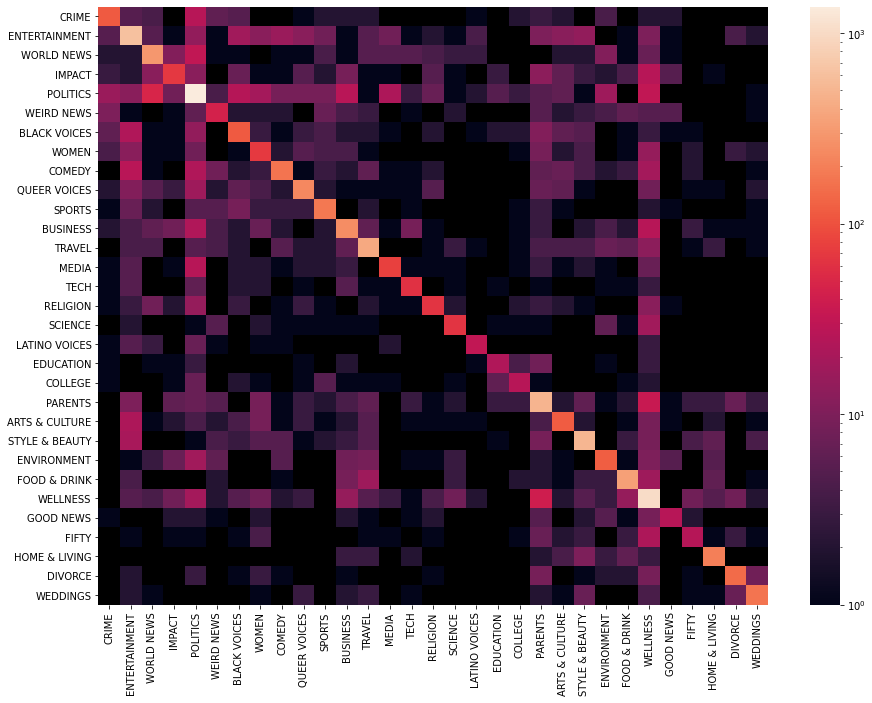

In [36]:
df_cm = pd.DataFrame(confusion_mat, index = list(label.values()), columns = list(label.values()))
# plt.rcParams['figure.figsize'] = (20,20)
cm = sns.color_palette("rocket", as_cmap=True)
cm.set_bad("black")
heatmap = sns.heatmap(df_cm, norm=LogNorm(), cmap=cm, xticklabels=True, yticklabels=True)
fig = plt.gcf()
fig.set_size_inches((15, 11))
fig.savefig(model_name + "_confusion_heatmap.pdf")
plt.show()

The confusion matrix is nearly symmetric. Only the `WELLNESS` category tends to be slightly overpredicted. The near symmetry of the confusion matrix shows that the imbalanced dataset is not a major problem. This is in line with the observation that adding class weights to the model did not have a major impact. 

# Conclusion

We can see that we have problems with the two largest categories `POLITICS` and `WELLNESS`. Additionally, the two categories blur with other categories or are outright super-categories of other categories. For example there are headlines which are clearly concerned with women rights, however they have the true label `POLITICS`. There are multiple of such examples. In particular, we can observe that many headlines allow for multiple reasonable classifications. This presumption is supported by the fact that the top-3 accuracy metric shows a significantly higher value. It means that the classifier recognizes that multiple categories can fit a headline and that it can identify them. However, it loses accuracy when having to choose from the candidate categories. 

In [37]:
wrong_predictions[(wrong_predictions["true_category"] == "POLITICS") & (wrong_predictions["predicted_category"] == "WOMEN")]

,description,true_category,predicted_category
36500,These Muslim Teens Just Went To Their First Women's March. They Could Have Led It.,POLITICS,WOMEN
28001,Women In The U.S. Don’t Live In A Dystopian Hellscape. Yet.,POLITICS,WOMEN
32459,16 Historical Polls Show Just How Far Women Have Come,POLITICS,WOMEN
56916,Brock Turner's Dad Gave Tone-Deaf Plea For Lenient Sentence In Son's Sexual Assault Case,POLITICS,WOMEN
34666,The Snowflake's Guide To Staying Sane In The Age Of You Know Who,POLITICS,WOMEN
65992,The Single American Woman,POLITICS,WOMEN
43569,Lucy Flores Was The Perfect Candidate For EMILY’s List — Until She Wasn’t,POLITICS,WOMEN
122806,What I Realized When I Finally Decided To Sign Up For Food Stamps,POLITICS,WOMEN
61230,Here's The Problem With The Latest Planned Parenthood Video Conspiracy Theory,POLITICS,WOMEN
49211,She Was Raped During Study Abroad. Then Her School Said She Couldn't Talk About It.,POLITICS,WOMEN


Hence, it might be impossible for a classifier to learn the difference. Using class weights to overcome the imbalancement did not help with this issue. Since we are dealing with a hierachy of categories, the class weights would push the classifier to rather predict for example `WOMEN` than `POLITICS` when in doubt. Since we have way more `POLITICS` labels, in such a case it would be wiser to predict `POLITICS` if the prediction is unclear. In our sample above we see cases where the classifier's prediction reasonably matches the `WOMEN` category even though `POLITICS` would be the correct label.  

Another major confusion is between `WELLNESS` and `PARENTS`:

In [38]:
wrong_predictions[(wrong_predictions["true_category"] == "PARENTS") & (wrong_predictions["predicted_category"] == "WELLNESS")]

,description,true_category,predicted_category
159700,In This Fragile Sacred Space,PARENTS,WELLNESS
92288,Missing Out: The Art of Not Missing It,PARENTS,WELLNESS
135283,The Reason for the Season: Have We Lost Our Way?,PARENTS,WELLNESS
193587,"Kimber Michelle Brown, 5-Year-Old, Dies From Cold Medicine Overdose",PARENTS,WELLNESS
140121,There's an App for That: A Speech Language Therapist's Perspective,PARENTS,WELLNESS
181481,Older Fathers: Now We Know More About the Risks Their Children Face,PARENTS,WELLNESS
190514,Many Pregnant Women May Not Get STD Tests,PARENTS,WELLNESS
140930,Just Like Me: Understanding the Common Human Condition,PARENTS,WELLNESS
42117,The Lessons One Woman Learned From Her Sister With A Rare Disease,PARENTS,WELLNESS
140065,'You've Got to Be Carefully Taught',PARENTS,WELLNESS
